# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

**Lorena Dorado**

his notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
# import nltk
# nltk.download()

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
# For visualization
import matplotlib.pyplot as plt

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/Dell/Desktop/509/M1_ads-tm-scrape/"
# data_location = "/users/chandler/dropbox/teaching/repos/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    # ratio of unique tokens to the total number of tokens in the IF words in text
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens using Counter
        most_common = Counter(tokens).most_common(5)
        print(f"\nThe five most common tokens:")
        for token, count in most_common:
            print(f"  {token}: {count}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.

The five most common tokens:
  text: 3
  here: 2
  example: 2
  is: 1
  some: 1


Q: Why is it beneficial to use assertion statements in your code? 

**A: Assertion statements are useful for catching bugs by validating assumptions and ensuring that functions return expected results. They help stop the program or raise an error message when specified conditions are not satisfied.**

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data
lyrics_data = defaultdict(dict) # Nested dictionary
for artist in ['daftpunk', 'eagles']:
    artist_folder = os.path.join(data_location, lyrics_folder, artist) # path to artist folder
    for song_file in os.listdir(artist_folder): # Iterate thru folder
        with open(os.path.join(artist_folder, song_file), 'r', encoding='utf-8') as f:
            lyrics_data[artist][song_file] = f.read() # Store lyrcs in nested dictionary

In [7]:
# Read in the twitter data
twitter_descriptions = defaultdict(list)
artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}

for artist, filename in artist_files.items(): # Loop thru artists and files
    try:
        with open(os.path.join(data_location, twitter_folder, filename), 'r', encoding='utf-8') as f:
            # Read each line as a description
            for line in f:
                if line.strip():  # Skip empty lines
                    try:
                        # Each line is a description
                        description = line.strip()
                        # Skip artifacts or non-text
                        if description and not description.startswith('{') and not description.startswith('['):
                            twitter_descriptions[artist].append(description)
                    except Exception as e:
                        print(f"Error processing line in {filename}: {e}")
    except Exception as e:
        print(f"Error reading {filename}: {e}")

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [8]:
punctuation = set(punctuation) # speeds up comparison

# Data Cleaning
def clean_text(text):
    """Remove punctuation, split on whitespace, fold to lowercase, and remove stopwords"""
    # Skip if not a string
    if not isinstance(text, str):
        return []
    # Convert to lowercase and remove punctuation
    cleaned = ''.join(char.lower() for char in text if char not in punctuation)
    # Tokenize and remove stopwords
    tokens = [word for word in cleaned.split()
              if word not in sw
              and not word.isdigit() # remove numbers
              and word.strip()]
    return tokens

In [9]:
# create your clean twitter data here
clean_twitter = defaultdict(list)
for artist, descriptions in twitter_descriptions.items():
    for desc in descriptions:
        clean_tokens = clean_text(desc)
        if clean_tokens:  # Only add if we got valid tokens
            clean_twitter[artist].extend(clean_tokens)

In [10]:
# create your clean lyrics data here
clean_lyrics = defaultdict(list)
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        clean_lyrics[artist].extend(clean_text(lyrics))

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

## Descriptions Statistics from Twitter Data

In [11]:
# calls to descriptive_stats here
for artist in clean_twitter:
    print(f"\nStatistics for {artist}'s followers' descriptions:")
    descriptive_stats(clean_twitter[artist])


Statistics for cher's followers' descriptions:
There are 30052904 tokens in the data.
There are 6605053 unique tokens in the data.
There are 200372525 characters in the data.
The lexical diversity is 0.220 in the data.

The five most common tokens:
  love: 221728
  im: 141980
  usa: 140893
  life: 125699
  new: 106519

Statistics for robyn's followers' descriptions:
There are 2784554 tokens in the data.
There are 762752 unique tokens in the data.
There are 18723407 characters in the data.
The lexical diversity is 0.274 in the data.

The five most common tokens:
  music: 16049
  sweden: 12721
  love: 12190
  new: 10249
  stockholm: 9701


## Descriptions Statistics for Lyrics from Module 1

In [12]:
for artist in clean_lyrics:
    print(f"\nStatistics for {artist}'s lyrics:")
    descriptive_stats(clean_lyrics[artist])


Statistics for daftpunk's lyrics:
There are 4913 tokens in the data.
There are 849 unique tokens in the data.
There are 24555 characters in the data.
The lexical diversity is 0.173 in the data.

The five most common tokens:
  around: 150
  world: 149
  rock: 105
  love: 87
  get: 78

Statistics for eagles's lyrics:
There are 11680 tokens in the data.
There are 2120 unique tokens in the data.
There are 57387 characters in the data.
The lexical diversity is 0.182 in the data.

The five most common tokens:
  dont: 166
  know: 150
  love: 141
  youre: 118
  im: 117


Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

**A: The top words would likely include common stopwords like "the" or numbers that appear in the song file that is not part of the lyric. These frequent but less meaningful words would probably overshadow more informative words that provide better insights about the songs.**

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

**A: Like Professor's comment, I also had the expectation that the Eagles would proportionally have more words and more unique words than Daft Punk. However, the lexical diversity between the two artists suggests that their songs might have similar levels of vocabulary variation. Daft Punk's lexical diversity was 0.174, while the Eagles' was 0.182. I initially thought Daft Punk's lexical diversity would be significantly lower due to their typically repetitive lyrics, compared to the Eagles' narrative songwriting with a broader vocabulary.**



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [13]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [14]:
# Your code here
# Get emoji from description
def get_emojis(text):
    return [c for c in text if emoji.is_emoji(c)] # List comprehension for emojis
    
for artist, descriptions in twitter_descriptions.items(): # Loop thru artist and twitter desc
    all_emojis = []
    for desc in descriptions:
        all_emojis.extend(get_emojis(desc)) # add to all_emojis list
    print(f"\n{artist}'s top 10 emojis:")
    print(Counter(all_emojis).most_common(10)) # most common method


cher's top 10 emojis:
[('❤', 94506), ('🌈', 66291), ('♥', 48059), ('🏳', 47174), ('✨', 45846), ('🌊', 31234), ('💙', 31050), ('🏻', 25195), ('✌', 21963), ('💜', 21571)]

robyn's top 10 emojis:
[('🌈', 6086), ('❤', 5635), ('🏳', 4641), ('♥', 4249), ('✨', 3217), ('🏻', 1751), ('✌', 1495), ('♀', 1347), ('🏼', 1340), ('💙', 1200)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [15]:
# Your code here
# get hashtags from description
def get_hashtags(text):
    # Use regularexpressions and match hashtags followed by characters
    return re.findall(r'#\w+', text)

for artist, descriptions in twitter_descriptions.items():
    all_hashtags = []
    for desc in descriptions:
        all_hashtags.extend(get_hashtags(desc))
    print(f"\n{artist}'s top 10 hashtags:")
    print(Counter(all_hashtags).most_common(10))


cher's top 10 hashtags:
[('#BLM', 10100), ('#Resist', 6161), ('#BlackLivesMatter', 4888), ('#resist', 3860), ('#FBR', 3330), ('#1', 3111), ('#TheResistance', 3044), ('#blacklivesmatter', 2738), ('#Resistance', 1953), ('#RESIST', 1878)]

robyn's top 10 hashtags:
[('#BlackLivesMatter', 356), ('#BLM', 345), ('#1', 228), ('#blacklivesmatter', 222), ('#music', 175), ('#Music', 114), ('#EDM', 87), ('#LGBTQ', 76), ('#blm', 60), ('#TeamFollowBack', 59)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [16]:
# Your code here
for artist, songs in lyrics_data.items():
    title_words = []  # Initialize a list to store words from song titles
    
    for song_file, lyrics in songs.items():
        # Get the first line of the lyrics (should be song title)
        first_line = lyrics.splitlines()[0]
        
        # Clean and tokenize title, then add words to the list
        title_words.extend(clean_text(first_line))
    
    # Print top 5 most common words in artists' song titles
    print(f"\n{artist}'s top 5 words in song titles:")
    print(Counter(title_words).most_common(5))


daftpunk's top 5 words in song titles:
[('time', 4), ('love', 3), ('face', 2), ('fragments', 2), ('life', 2)]

eagles's top 5 words in song titles:
[('live', 11), ('new', 5), ('love', 5), ('long', 4), ('time', 4)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

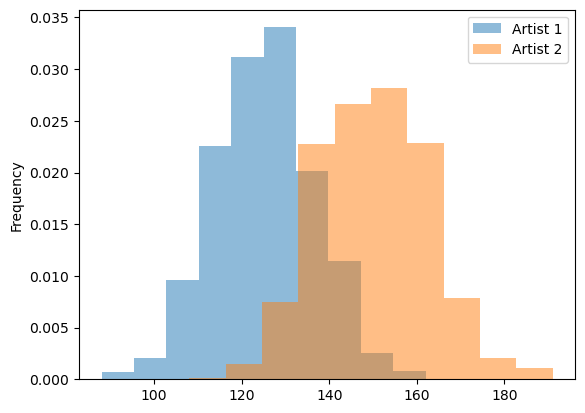

In [17]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

**A: The regular expression \s+ matches one or more whitespace characters, including spaces, tabs, newlines, carriage returns, form feeds, and vertical tabs. The \s matches any type of whitespace, while the + quantifier ensures it matches one or more occurrences. This expression is commonly used to collapse multiple whitespace characters into a single space.**


In [18]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

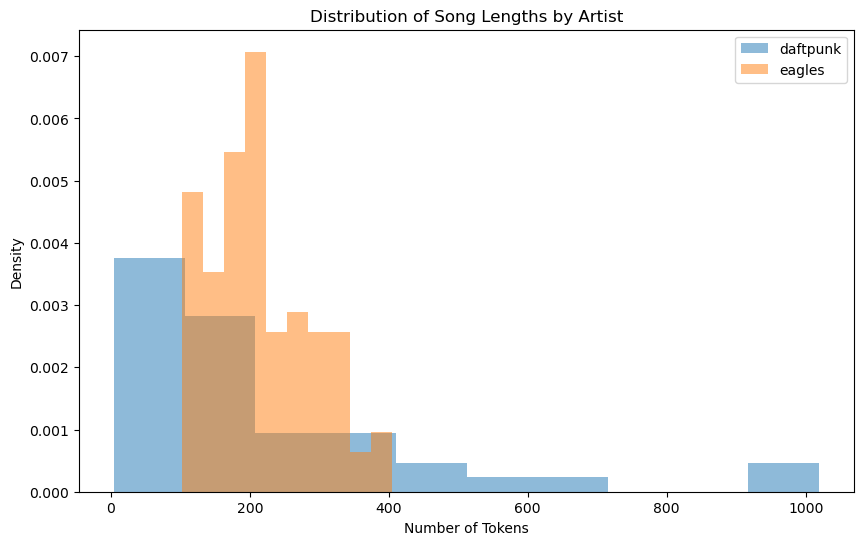

In [19]:
# Your lyric length comparison chart here. 
# Store song lengths and artist into lists
song_lengths = []
song_artists = []

# Iterate over artists and their songs in lyrics_data
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        tokens = tokenize_lyrics(lyrics) # Tokenize
        song_lengths.append(len(tokens))
        song_artists.append(artist)

# Create dataframe for visualization
length_df = pd.DataFrame({
    'artist': song_artists,
    'length': song_lengths
})

plt.figure(figsize=(10, 6))
length_df.groupby('artist')['length'].plot(kind="hist", density=True, alpha=0.5, legend=True)
plt.title('Distribution of Song Lengths by Artist')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.show()

This distribution was expected given the artists' different styles. The Eagles follows a more conventional song structures as a rock band. On the other hand, Daft Punk is known for more short electronic tracks to longer compositions.

#### References

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly. 

OpenAI. (2025). ChatGPT (Version 4.0) [AI model]. OpenAI. https://openai.com/chatgpt